In [3]:
import sys
sys.path.append('/home/emastr/phd/')

import torch
import time
import numpy as np
from stokes2d.robin_solver import solveRobinStokes_fromBasis
from util.basis_scaled import ScaleShiftedBasis
from util.basis_scaled import ScaleShiftedBasisProduct
from util.basis_scaled import Basis, FourBasis, BasisProduct, ChebBasis
from util.plot_tools import *
from boundary_solvers.geometry import MacroGeom
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.gmres import gmres as torch_gmres

## Conclusions

GMRES doesn't work for solver since eigenvalues scattered on disk around zero.
Standard solver super fast for alpha = 0 but significantly slower (10x) otherwise.
Idea to iterate between Neumann and Dirichlet might work

\begin{equation}
    u = \beta - \alpha \partial u
\end{equation}

In [4]:

xDim = 201
yDim = 201
plot = True
kwargs = {"dom": [[0.,1.],[-1.,1.]]}

#scale = [Lx, Ly/2]
#shift = [0,0]
dom = kwargs.pop("dom", [[0., 1.], [-1., 1.]])

Lx = dom[0][1]-dom[0][0]
Ly = dom[1][1]-dom[1][0]

xBasis = FourBasis
yBasis = ChebBasis

psi = lambda x, y: np.exp(y*np.cos(2*np.pi*x / Lx))
p = lambda x,y: 1. / ((y/Ly)**2 + 1) * np.arctan(np.cos(2*np.pi*x / Lx))
a = lambda x: 10. / (np.sin(2*np.pi*x/Lx)+2)


p_basis = ScaleShiftedBasisProduct.fromFunctionInDomain(p, dom, xDim, yDim, xBasis, yBasis)
psi_basis = ScaleShiftedBasisProduct.fromFunctionInDomain(psi, dom, xDim, yDim, xBasis, yBasis)
alpha_basis = ScaleShiftedBasis.fromFunctionInDomain(a, dom[0], xBasis, xDim)

# U and V velocity components
u_basis = psi_basis.diff(0, 1)
v_basis = -1. * psi_basis.diff(1, 0)

# Divergence field
div_basis = u_basis.diff(1, 0) + v_basis.diff(0, 1)

# Laplacian and pressure gradients
lapu_basis = u_basis.diff(2, 0) + u_basis.diff(0, 2)
lapv_basis = v_basis.diff(2, 0) + v_basis.diff(0, 2)
dxp_basis = p_basis.diff(1,0)
dyp_basis = p_basis.diff(0,1)


### Problem parameters

# Inner force
f_basis = lapu_basis - dxp_basis
g_basis = lapv_basis - dyp_basis

# PDE x component
pde_basis = lapu_basis - dxp_basis - f_basis

# Upper boundary condition
uTop_basis = u_basis.reduce_eval(dom[1][1], axis=1)
vTop_basis = v_basis.reduce_eval(dom[1][1], axis=1)


# Lower boundary velocities
uBot_basis = u_basis.reduce_eval(dom[1][0], axis=1)
vBot_basis = v_basis.reduce_eval(dom[1][0], axis=1)


# Lower boundary slip coefficient
duBot_basis = u_basis.diff(0,1).reduce_eval(dom[1][0], axis=1)
beta_basis = (uBot_basis + alpha_basis * duBot_basis)



uSol_basis,vSol_basis,info = solveRobinStokes_fromBasis(f_basis, 
                                                        g_basis, 
                                                        alpha_basis, 
                                                        uTop_basis, 
                                                        beta_basis, 
                                                        vTop_basis, 
                                                        vBot_basis,
                                                        dom, xDim, yDim, tol=1e-8)

/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


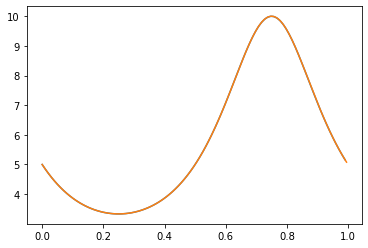

In [5]:
u_bot = uSol_basis.reduce_eval(dom[1][0], axis=1)
dy_u_bot = uSol_basis.diff(0,1).reduce_eval(dom[1][0], axis=1)

u_true = u_basis.reduce_eval(dom[1][0], axis=1)
dy_u_true = u_basis.diff(0,1).reduce_eval(dom[1][0], axis=1)

alpha = lambda x: -(u_bot(x)-beta_basis(x))/dy_u_bot(x)

x = alpha_basis.grid()

alpha_basis.plot(plt.gca(), dim=100)
plt.plot(x, alpha(x))
#plt.plot(x, u_bot(x))
#plt.plot(x, u_true(x))
#
#plt.plot(x, dy_u_bot(x))
#plt.plot(x, dy_u_true(x))

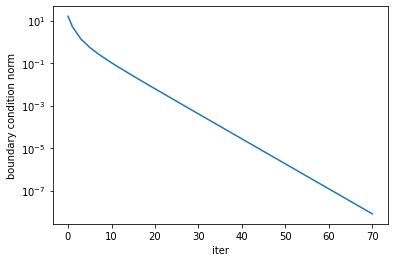

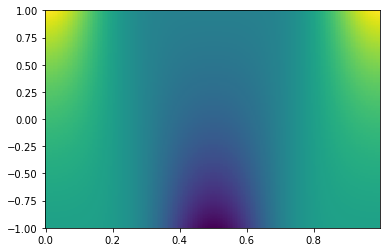

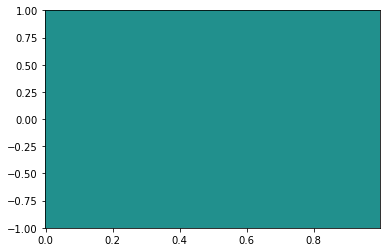

In [6]:
plt.semilogy(info["resList"])
plt.xlabel("iter")
plt.ylabel("boundary condition norm")


plt.figure()
uSol_basis.plot(plt.gca())

plt.figure()
tol = 1e-8
(uSol_basis - u_basis).plot(plt.gca(), vmin=-tol, vmax=tol)

In [7]:
print(sum(info["betaCompTime"]), sum(info["solveTime"]), np.mean(info["solveTime"]), info["buildTime"])
#plt.figure(figsize=(20,20))
#plt.imshow(np.log(np.abs((B).todense())), vmin=-3, vmax=3)

5.564362525939941 9.241655826568604 0.1301641665713888 0.07513809204101562
